In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
from torchviz import make_dot

In [3]:
%load_ext autoreload
%autoreload 2
from context import *

In [4]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='mps')

### Meta Device Bug

In [13]:
x0 = torch.randn(1,2)

In [10]:
ode = ODEBijector(Dynamic(torch.nn.Linear(2,2), hyper_dim=2))
ode

ODEBijector(
  (odefunc): ODEFunc(
    (f): Dynamic(
      (func_module): FunctionalModule(
        (stateless_model): Linear(in_features=2, out_features=2, bias=True)
      )
      (hyper_net): Sequential(
        (0): Linear(in_features=1, out_features=2, bias=True)
        (1): Tanh()
        (2): Linear(in_features=2, out_features=6, bias=True)
      )
    )
  )
)

In [11]:
for p in ode.parameters():
    print(p)

Parameter containing:
tensor(..., device='meta', size=(2, 2))
Parameter containing:
tensor(..., device='meta', size=(2,))
Parameter containing:
tensor([[0.8321],
        [0.1093]], requires_grad=True)
Parameter containing:
tensor([0.0754, 0.4011], requires_grad=True)
Parameter containing:
tensor([[ 0.2877, -0.0235],
        [ 0.1690,  0.0763],
        [ 0.1532, -0.6153],
        [-0.1894,  0.0365],
        [-0.4347, -0.2899],
        [ 0.4842, -0.0847]], requires_grad=True)
Parameter containing:
tensor([ 0.1976,  0.6300,  0.3712, -0.1540, -0.5269,  0.5459],
       requires_grad=True)


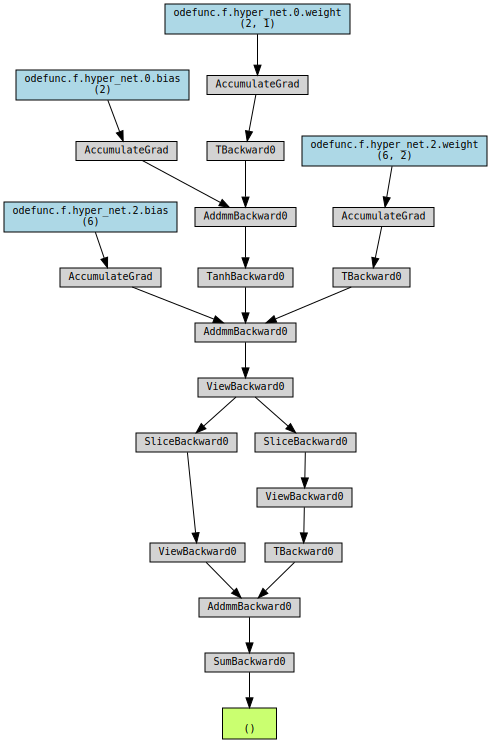

In [14]:
y = ode.odefunc(torch.tensor(0.), x0).sum()
make_dot(y, params=dict(ode.named_parameters()))

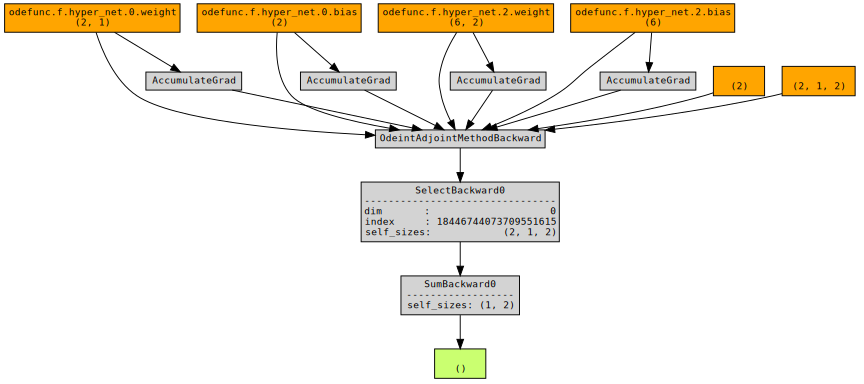

In [15]:
y = ode(x0, 0., 1.)[0].sum()
make_dot(y, params=dict(ode.named_parameters()),show_attrs=True, show_saved=True)

In [16]:
ode(x0, 0., 1.)[0].sum().backward()

In [5]:
mdl = Dynamic(torch.nn.Linear(1,1), hyper_dim=2)
x = torch.ones(1,1)

In [6]:
mdl.params

(Parameter containing:
 tensor([[0.8589]], requires_grad=True),
 Parameter containing:
 tensor([-0.9405], requires_grad=True))

In [7]:
list(mdl.func_module.parameters())

[Parameter containing:
 tensor(..., device='meta', size=(1, 1)),
 Parameter containing:
 tensor(..., device='meta', size=(1,))]

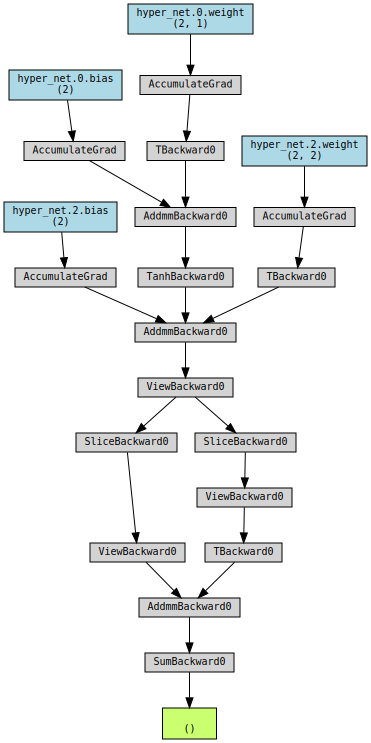

In [9]:
y = mdl(torch.tensor(0.), x).sum()
make_dot(y, params=dict(mdl.named_parameters()))

### HMC 

In [3]:
energy = lambda x: x.square().sum(-1)/2
hmc = HMCSampler(energy, torch.zeros(3,2))
hmc.sample()

tensor([[-0.2973,  0.1680],
        [-0.8113, -1.8355],
        [ 0.0858,  0.1091]])

In [8]:
class LatentHMCSampler():
    ''' Latent space Hamiltonian Monte Carlo sampler 
    
        Example:
        flow = RGFlow([1], 1)
        energy = lambda x: x.square().sum((-1,-2))/2
        lhmc = LatentHMCSampler(flow, energy, torch.randn(20,1,1))
        lhmc.sample()
        
        Parameters:
            flow :: RGFlow - bijective flow, with encode and decode methods
            energy :: func or torch.Module - energy function
            x0 :: torch.Tensor - initial configuration of x
        '''
    def __init__(self, flow, energy, x0, **kwargs):
        self.flow = flow
        self.energy = energy
        z0, *_ = self.flow.encode(x0)
        self.latent_sampler = HMCSampler(self.latent_energy, z0.detach(), **kwargs)
    
    def latent_energy(self, z, mode='jf', **kwargs):
        ''' compute induced energy for latent variable 
            E(z) = E(x) - log det(dx/dz) '''
        x, logJ, *rest = self.flow.decode(z, mode=mode, **kwargs)
        return self.energy(x, **kwargs) - logJ
    
    def sample(self, x=None, **kwargs):
        ''' generate samples 
            Input:
                x :: torch.Tensor - initial samples (optional)
                    if not provided, load sampler's saved z 
                (other options see HMCSampler) '''
        if x is None:
            z = None
        else:
            z, *_ = self.flow.encode(x)
            z = z.detach()
        z = self.latent_sampler.sample(z, **kwargs)
        x, *_ = self.flow.decode(z)
        return x

In [9]:
flow = RGFlow([1],1)
flow.encode(torch.randn(5,1,1))

(tensor([[[ 0.9161]],
 
         [[-0.2502]],
 
         [[-0.3562]],
 
         [[ 0.0980]],
 
         [[-0.9038]]], grad_fn=<CatBackward0>),)

In [17]:
def energy(x, **kwargs):
    return x.square().sum((-1,-2))/2
energy(torch.randn(5,1,1))

tensor([2.2806e+00, 5.6331e-02, 2.2163e-03, 4.4145e-01, 1.1240e-01])

In [19]:
smp = LatentHMCSampler(flow, energy, torch.randn(20,1,1))

In [23]:
with torch.no_grad():
    smp.sample()

In [33]:
smp.sample(iters=1, traj_len=1, atol=1e-3, rtol=1e-2)

tensor([[[-0.9299]],

        [[ 1.4082]],

        [[-0.3855]],

        [[ 0.5483]],

        [[-0.4967]],

        [[ 0.4056]],

        [[ 2.7243]],

        [[-0.3909]],

        [[ 0.6617]],

        [[ 1.7968]],

        [[ 0.2261]],

        [[ 0.8733]],

        [[-0.7578]],

        [[ 0.1778]],

        [[-1.6277]],

        [[-0.0935]],

        [[ 0.0128]],

        [[-0.4070]],

        [[ 0.7339]],

        [[-1.2325]]], grad_fn=<SelectBackward0>)

In [19]:
rg = RGGenerator([1],1).to(device)

In [20]:
rg.base_dist.loc

tensor([[0.]], device='mps:0')

In [23]:
p = ShapedNormal([1,1])
p.log_prob(p.sample(2))

tensor([-1.5786, -1.6433])

In [24]:
torch.zeros(3,2)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

### Bayes Predictor

In [156]:
from math import prod
class RGPredictor(torch.nn.Module):
    ''' RG flow-based predictive model
        
        Parameters:
            shape :: torch.Size - input shape
            dim :: int - input dimension
            out_dim :: int - output dimension
    '''
    def __init__(self, shape, dim, out_dim, **kwargs):
        super().__init__()
        self.rgflow = RGFlow(shape, dim, **kwargs)
        self._base_dist = ShapedNormal([dim, *self.rgflow.out_shape])
        self.para_size = prod(self._base_dist.event_shape)
        self.para_net = torch.nn.Sequential(
                            torch.nn.Linear(out_dim, 4*out_dim),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4*out_dim, 2*self.para_size))
    
    def base_dist(self, y=None):
        if y is None:
            return self._base_dist
        else:
            para = self.para_net(y)
            loc = para[...,:self.para_size]
            scale = para[...,self.para_size:].exp()
            loc = loc.view(loc.shape[:-1]+self._base_dist.event_shape)
            scale = scale.view(scale.shape[:-1]+self._base_dist.event_shape)
            return self._base_dist.new(loc, scale)
    
    def log_prob(self, x, y=None, mode='jf', **kwargs):
        ''' log conditional probability estimation 
            Input:
                x :: torch.Tensor (N, dim, *shape) - data 
                y :: torch.Tensor (N, out_dim) - prediction
                     if y = None, returns log of marginal probability
            Ouput:
                log p(x|y) :: torch.Tensor (N,) - log probability '''
        z, logJ, *rest = self.rgflow.encode(x, mode=mode, **kwargs)
        logpz = self.base_dist(y).log_prob(z)
        return logpz + logJ
    
    def log_bayes(self, x, y, mode='f', **kwargs):
        ''' log Bayes factor estimation 
            log K(x|y) = log p(x|y) - log p(x)
            Input:
                x :: torch.Tensor (N, dim, *shape) - data 
                y :: torch.Tensor (N, out_dim) - prediction
            Ouput:
                log K(x|y) :: torch.Tensor (N,) - log Bayes factor '''
        z, *rest = self.rgflow.encode(x, mode=mode, **kwargs)
        logK = self.base_dist(y).log_prob(z) - self.base_dist().log_prob(z)
        return logK
    
    def nll_loss(self, x, y, lk=0.01, lg=0.01, mode='jf_reg', **kwargs):
        ''' compute negative log likelihood loss given training samples
            L = - log p(x|y) - log p(x) + regs...
            Input:
                x :: torch.Tensor (N, dim, *shape) - data 
                y :: torch.Tensor (N, out_dim) - prediction
                lk :: real - kinetic energy regularization strength
                lg :: real - gradient energy regularization strength
            Output:
                loss :: torch.Tensor (scalar) - regularized loss
                -logp :: torch.Tensor (scalar) - negative log likelihood
                Ek :: torch.Tensor (scalar) - kinetic energy
                Eg :: torch.Tensor (scalar) - gradient energy
        '''
        z, logJ, Ek, Eg = self.rgflow.encode(x, mode=mode, **kwargs)
        logpz_y = self.base_dist(y).log_prob(z)
        logpz = self.base_dist().log_prob(z)
        #logp = logpz_y + logpz + 2*logJ
        logp = logpz_y + logJ
        logp, Ek, Eg = [val.mean() for val in (logp, Ek, Eg)]
        return -logp + lk * Ek + lg * Eg, -logp, Ek, Eg

In [157]:
mdl = RGPredictor([1], 1, 1, hdims=[8,2], hyper_dim=8)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)
y = torch.tensor([[-1.],[1.]])
x = torch.tensor([[[-1.]],[[1.]]])

In [175]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.nll_loss(x, y, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

-0.30 -0.32  0.50  1.88
-0.77 -0.80  0.58  2.50
-0.74 -0.77  0.57  2.53
-6.99 -7.14  0.47 14.46
 1.08  1.07  0.22  0.31
 0.43  0.41  0.21  1.51
 1.62  1.62  0.22  0.00
 1.64  1.64  0.23  0.01
 0.52  0.51  0.23  1.33
 0.80  0.79  0.22  1.04


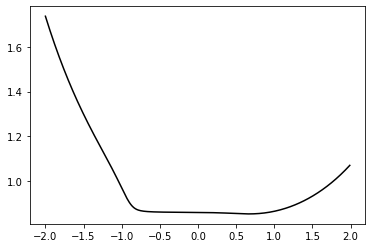

In [155]:
mdl.eval()
xs = torch.arange(-2,2,0.01)
with torch.no_grad():
    ps = mdl.log_bayes(xs.view(-1,1,1), torch.tensor([-1.]), div='exact').exp()
plt.plot(xs, ps, 'k-');

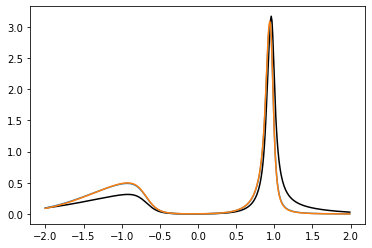

In [176]:
mdl.eval()
xs = torch.arange(-2,2,0.01)
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), div='exact').exp()
plt.plot(xs, ps, 'k-');
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), y[0], div='exact').exp()
plt.plot(xs, ps);
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), y[1], div='exact').exp()
plt.plot(xs, ps);

In [80]:
mdl.base_dist(torch.tensor([1.])).dist.log_prob()

tensor([[[0.4388]]], grad_fn=<ExpandBackward0>)